# Example 3: State matrix with different kinds of clusters of eigenvalues

The number of real and complex eigenvalues in each block of the state matrix, decides the number of first- and second-order neurons in the corresponding horizontal layer (see the paper for definitions of first-order and second-order neurons). Thus, each horizontal layer can have only first-order neurons, or only second-order neurons, or both. 

The goal of the following toy example is to demonstrate that a dynamic neural network consisting of all kinds of the above-mentioned horizontal layers can simulate an LTI system accurately and thus validate the implementation.

In [10]:
import sys
sys.path.insert(0, "../../")
# Import packages
import numpy as np
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Import modules from dynamic neural network
from dynamic_neural_networks.utils.helper_functions import *
from dynamic_neural_networks.data.horizontal_layers_all_types import get_ssm
from dynamic_neural_networks.transformations.helper_functions import *
from dynamic_neural_networks.transformations.sorted_real_schur_forms import *
from dynamic_neural_networks.model.state_space_model import *
from dynamic_neural_networks.model.dnn import *

np.random.seed(seed=1)  # Set a random seed
expensive_asserts = False  # No asserts

Note: Our data consists of the state-space matrices $A, B, C, D$ instead of the typically available input-output pairs in supervised learning tasks! 

In [11]:
# Data: State-space matrices A, B, C, D
# Dimensions of the state-space matrices for example 3
d_state = 134  # State dimension
d_in = 10  # Input dimension
d_out = 4  # Output dimension
ssm_dim = [d_state, d_in, d_out]  # Dimensions of the state-space model

# Get state-space matrices for the example 3 from the paper
A, B, C, D = get_ssm(d_in, d_state, d_out)
ssm = state_space_model(A, B, C, D)

# Uncomment the following see the sparsity pattern of A
# plt.spy(A)

In [12]:
# Input to a dynamic neural network and the numerical solvers
# Timesteps
t_0 = 0.0  # Initial time
t_end = 10.0  # Final time
dt = 0.1  # Determines the input-signal sampling frequency
timesteps = np.arange(t_0, t_end + dt, dt)  # All time-steps

# Method to interpolate the input function within each time-step
u_interp = "piecewise_linear"  # 'piecewise_constant', 'piecewise_linear', 'sample'

# Compute u(t)
u = np.zeros((len(timesteps), d_in))
for i in range(d_in):
    u[:, i] = np.sin(
        i * timesteps / 2.0
    )  # Each input channel with a different frequency

# Compute u'(t) using first-order finite differences
ddt_u = np.zeros((len(timesteps), d_in))
for t in range(0, len(timesteps) - 1):
    ddt_u[t, :] = (u[t + 1, :] - u[t, :]) / (timesteps[t + 1] - timesteps[t])

# Set the inputs
inputs = [u, ddt_u]

# Ignore the following cell unless: u_interp == 'sample'
if u_interp == "sample":
    t = timesteps
    i = np.arange(0, d_in, 1)
    u = u(np.reshape(t, (len(t), 1)), np.reshape(i, (1, len(i))))

In [13]:
# Dynamic Neural Network Parameters
n_clusters = 6  # Number of clusters of close eigenvalues
outer_loop = "timesteps"  # 'neurons', 'timesteps'
ode_solver_rel_tol = 1e-10 #10  # relative tolerance for ODE solver
ode_solver_abs_tol = 1e-10 #10  # absolute tolerance for ODE solver
clustering_alg = KMeans(
    n_clusters=n_clusters, random_state=0, n_init="auto"
)  # Clustering algorithm
params = forward_pass_parameters(
    outer_loop=outer_loop,
    ssm_input_interpolation=u_interp,
    solver_routine="solve_ivp",
    ode_solver_params=ode_solver_parameters(
        atol=ode_solver_abs_tol, rtol=ode_solver_rel_tol, ode_solver="DOP853"
    ),
)  # Parameters concerning forward pass of a DyNN

In [14]:
# Simulate the LTI system using python routine lsim
y_lsim = numerical_simulation_lsim(timesteps, u, ssm, interp=True)

# Simulate the LTI system using python routine solve_ivp
y_solve_ivp, nfe_solver = numerical_simulation_ivp_solve(
    ssm,
    inputs,
    timesteps,
    u_interp,
    outer_loop,
    rtol=ode_solver_rel_tol,
    atol=ode_solver_abs_tol,
)

c:\Users\chinm\miniconda3\envs\dynn\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Condition number of the transformation matrix =  11.200396358811405


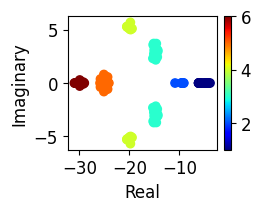

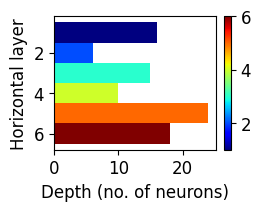

In [15]:
# Initialize the dynamic neural network
dynn = dynamic_neural_network(ssm=ssm)

# Compute architecture and parameters of the DyNN
dynn.fit(clustering_alg, verbose=0, show_plots=False)

# Condition number of the transformation matrix
print("Condition number of the transformation matrix = ", dynn.cond_num)

# Plot eigenvalue clusters and DyNN architecture
dynn.plot_architecture(figname="horizontal_layers", fig_size_1=(2.5, 2), fig_size_2=(2.5, 2), fontsize = 12)

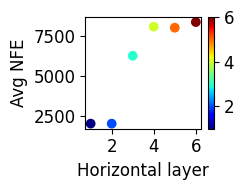

In [16]:
# Perform the forward pass and compute output of the DyNN
y_dynn = dynn.predict(inputs, timesteps, params)

# Plot: Avg number of function evaluations in each horizontal layer.
dynn.plot_NFE(figname="ex3", fig_size=(2.5, 2), fontsize = 12)

In [17]:
# Compute relative and absolute errors
abs_err_lsim = abs(y_dynn - y_lsim)
print("Max absolute error (DyNN and solver:lsim) :", np.amax(abs_err_lsim))

abs_err_solve_ivp = abs(y_dynn - y_solve_ivp)
print("Max absolute error (DyNN and solver:solve_ivp) :", np.amax(abs_err_solve_ivp))

abs_err_between_solvers = abs(y_lsim - y_solve_ivp)
print("Max absolute error between solvers :", np.amax(abs_err_between_solvers))

Max absolute error (DyNN and solver:lsim) : 2.9553471003751497e-06
Max absolute error (DyNN and solver:solve_ivp) : 2.9552392044607245e-06
Max absolute error between solvers : 1.0938405736737877e-10


In [18]:
plot_output_and_erros(
    timesteps, y_dynn, y_lsim, fig_size=(6.2, 2.2), save_fig=True, fig_name="hor_layers_sol_err.pdf", fontsize=12,labelpad = 25
)